In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks/PBRTQC'

/content/drive/MyDrive/Colab Notebooks/PBRTQC


In [3]:
#imports
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Collection
import numpy as np

In [4]:
df = pd.read_csv("sodium.csv")
df.head()

,Day,Result
0,1,142.0
1,1,139.0
2,1,131.0
3,1,132.0
4,2,139.0


In [5]:
mid_day = df['Day'].max()*0.8
train = df[df['Day'] <= mid_day]
test = df[df['Day'] > mid_day]
print(mid_day)
print(train.shape)
print(test.shape)

test_1 = test.copy()
ref = pd.concat([train, test_1], axis=0)

72.8
(50289, 2)
(14402, 2)


In [6]:
no_bias_total = 300  # Set the amount of result with no bias in a day
def simulation(x, bias):
  if len(x) >= no_bias_total:
          x.iloc[no_bias_total:] *= (1 + bias)
  return x

# Plotting Helper Functions

In [8]:
def plot_each_day_result (final):
  for day, group in final.groupby('Day'):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(group.index, group['Result'], label='Original Result', color='c')
    plt.plot(group.index, group['MA'], label='Moving Average', color='black')
    plt.axhline(y=group['UCL'].iloc[0], label='Upper Control Limit', linestyle='--', color='red')
    plt.axhline(y=group['LCL'].iloc[0], label='Lower Control Limit', linestyle='--', color='green')

    # Plot red dots for anomalies
    anomalies = group[group['Anomaly'] == True]
    plt.scatter(anomalies.index, anomalies['Result'], color='red', label='Anomaly')

    plt.title(f'Day {day} - Moving Average')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_all (final):
  # Create a single figure
  plt.figure(figsize=(10, 6))

  # Plot lines for 'Result', 'MA', 'UCL', and 'LCL'
  plt.plot(final.index, final['Result'], label='Original Result', color='c')
  plt.plot(final.index, final['MA'], label='Moving Average', color='black')
  plt.axhline(y=final['UCL'].iloc[0], label='Upper Control Limit', linestyle='--', color='red')
  plt.axhline(y=final['LCL'].iloc[0], label='Lower Control Limit', linestyle='--', color='green')

  # Plot red dots for anomalies
  anomalies = final[final['Anomaly'] == True]
  plt.scatter(anomalies.index, anomalies['Result'], color='red', label='Anomaly')

  # Set title, labels, legend, and grid
  plt.title('Moving Average')
  plt.xlabel('Data Point Index')
  plt.ylabel('Value')
  plt.legend()
  plt.grid(True)

  # Show the plot
  plt.show()

# Moving Average 

In [9]:
def calculate_control_limits(data, num_std_dev = 1.5):
    mean = np.mean(data)
    std_dev = np.std(data)

    # Calculate the upper and lower control limits
    ucl = mean + (num_std_dev * std_dev)
    lcl = mean - (num_std_dev * std_dev)

    return ucl, lcl

In [10]:
def test_simulation (bias_value, cl_threshold, window_size, train, test):
  ucl, lcl = calculate_control_limits(train['Result'], cl_threshold)


  test['Result'] = test.groupby('Day')['Result'].transform(lambda x: simulation(x, bias_value))

  final = pd.concat([train, test], axis=0)

  final['MA'] = final['Result'].rolling(window = window_size).mean()
  final['STD'] = final['Result'].rolling(window = window_size).std()
  final['UCL'] = ucl
  final['LCL'] = lcl

  final['Anomaly'] = (final['MA'] > final['UCL']) | (final['MA'] < final['LCL'])
  anomalies = final[final['Anomaly'] == True]

  return ucl, lcl, final, anomalies

In [11]:
def evaluation(final, ref):
  final['Actual'] = final['Result'] != ref['Result']
  final['Actual'] = final['Actual'].astype(bool)

  # Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
  truth_table_test = final[final['Day'] > mid_day]

  TP = ((truth_table_test['Actual'] == True) & (truth_table_test['Anomaly'] == True)).sum()
  TN = ((truth_table_test['Actual'] == False) & (truth_table_test['Anomaly'] == False)).sum()
  FP = ((truth_table_test['Actual'] == False) & (truth_table_test['Anomaly'] == True)).sum()
  FN = ((truth_table_test['Actual'] == True) & (truth_table_test['Anomaly'] == False)).sum()

  # Calculate Specificity, Sensitivity, Accuracy, FPR, and FNR
  specificity = TN / (TN + FP)
  sensitivity = TP / (TP + FN)
  accuracy = (TP + TN) / (TP + TN + FP + FN)
  FPR = FP / (FP + TN)
  FNR = FN / (FN + TP)

  # Print the calculated metrics
  print ("Test Bias (%):", bias)
  print("Specificity:", specificity)
  print("Sensitivity:", sensitivity)
  print("Accuracy:", accuracy)
  print("False Positive Rate (FPR):", FPR)
  print("False Negative Rate (FNR):", FNR)

# Results

In [12]:
bias = 0.2
threshold = 3
window_size = 70
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)

<ipython-input-10-bb87df3f819a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Result'] = test.groupby('Day')['Result'].transform(lambda x: simulation(x, bias_value))


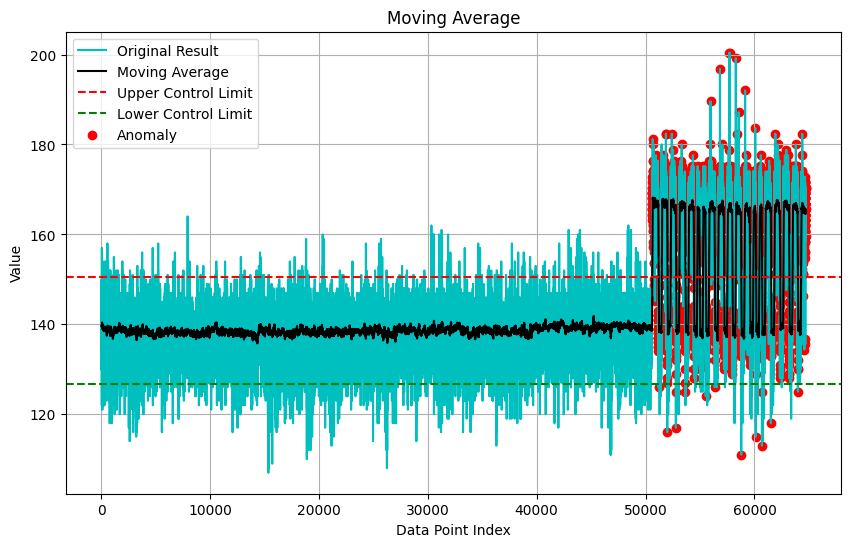

In [ ]:
plot_all(final)

In [ ]:
plot_each_day_result(final)


Output hidden; open in https://colab.research.google.com to view.

In [25]:
bias = -0.2
threshold = 3
window_size = 70
test = test_1.copy() # take back the original test
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)
evaluation(final, ref)

Test Bias (%): -0.2
Specificity: 0.8710526315789474
Sensitivity: 0.9374856354860952
Accuracy: 0.911192889876406
False Positive Rate (FPR): 0.12894736842105264
False Negative Rate (FNR): 0.06251436451390485


In [17]:
bias = 0.1
threshold = 3
window_size = 70
test = test_1.copy() # take back the original test
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)
evaluation(final, ref)

Test Bias (%): 0.1
Specificity: 0.98
Sensitivity: 0.8568145253964606
Accuracy: 0.9055686710179142
False Positive Rate (FPR): 0.02
False Negative Rate (FNR): 0.14318547460353942


In [18]:
bias = -0.1
threshold = 3
window_size = 70
test = test_1.copy() # take back the original test
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)
evaluation(final, ref)

Test Bias (%): -0.1
Specificity: 0.9633333333333334
Sensitivity: 0.8739370259710412
Accuracy: 0.9093181502569088
False Positive Rate (FPR): 0.03666666666666667
False Negative Rate (FNR): 0.12606297402895886


In [21]:
bias = 0.05
threshold = 3
window_size = 70
test = test_1.copy() # take back the original test
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)
evaluation(final, ref)

Test Bias (%): 0.05
Specificity: 1.0
Sensitivity: 0.0
Accuracy: 0.39577836411609496
False Positive Rate (FPR): 0.0
False Negative Rate (FNR): 1.0


In [20]:
bias = -0.05
threshold = 3
window_size = 70
test = test_1.copy() # take back the original test
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)
evaluation(final, ref)

Test Bias (%): -0.05
Specificity: 1.0
Sensitivity: 0.0
Accuracy: 0.39577836411609496
False Positive Rate (FPR): 0.0
False Negative Rate (FNR): 1.0
